# Feature Engineering

### Importing libraries

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
import pywt
%matplotlib inline

### Creating a list of all folder names

In [2]:
def list_folders(directory):
    folders = []
    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)
        if os.path.isdir(full_path):
            folders.append(entry)
    return folders

# Specify the directory you want to list folders from
directory_path = 'cropped_images/'

# Get the list of folder names
folder_names = list_folders(directory_path)

# folder_names

### Creating a dictionary of player name with all the image paths

In [3]:

# Creating a list of folder names of cropped images

cropped_folder_list = folder_names

folder_path_dict = {'Name':[],
                    'Paths':[]}



for folder_name in cropped_folder_list:
    
    list_1 = []

    folder_path = 'cropped_images'+'/{}'.format(folder_name)

    # Get a list of all files and directories in the specified folder
    files_and_directories = os.listdir(folder_path)

    # Filter only files (not directories) if needed
    files = [f for f in files_and_directories if os.path.isfile(os.path.join(folder_path, f))]

    # Now 'files' contains a list of file names in the folder
    # You can also get the full paths by using os.path.join() on each file name
    file_paths = [os.path.join(folder_path, f) for f in files]
    
    # changing the folder name into a proper name to be used as the dictionary key
    
    original_string = folder_name

    # Split the string based on underscores
    parts = original_string.split('_')

    # Join the first two parts with spaces
    clean_name = ' '.join(parts[:2])


    # Print the file paths
    for file_path in file_paths:
        list_1.append(file_path)
    
    folder_path_dict['Name'].append(clean_name)
    folder_path_dict['Paths'].append(list_1)
    
# folder_path_dict

In [4]:
# check

folder_path_dict['Name']

['alex albon',
 'carlos sainz',
 'charles leclerc',
 'daniel ricciardo',
 'esteban ocon',
 'fernando alonso',
 'george russell',
 'kevin magnussen',
 'lance stroll',
 'lando norris',
 'lewis hamilton',
 'logan sargeant',
 'max verstappen',
 'nico hulkenberg',
 'oscar piastri',
 'pierre gasly',
 'sergio perez',
 'valtteri bottas',
 'yuki tsunoda',
 'zhou guanyu']

In [5]:
# folder_path_dict['Paths']

### Converting racer names into numeric classes

In [6]:
class_dict = {}

count = 0
for racer_name in folder_path_dict['Name']:
    class_dict[racer_name] = count
    count = count + 1
    
class_dict

{'alex albon': 0,
 'carlos sainz': 1,
 'charles leclerc': 2,
 'daniel ricciardo': 3,
 'esteban ocon': 4,
 'fernando alonso': 5,
 'george russell': 6,
 'kevin magnussen': 7,
 'lance stroll': 8,
 'lando norris': 9,
 'lewis hamilton': 10,
 'logan sargeant': 11,
 'max verstappen': 12,
 'nico hulkenberg': 13,
 'oscar piastri': 14,
 'pierre gasly': 15,
 'sergio perez': 16,
 'valtteri bottas': 17,
 'yuki tsunoda': 18,
 'zhou guanyu': 19}

### Creating a function for wavelet transforming

In [7]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

### Creating the X and y variables for model training

In [8]:

X, y = [], []
for racer_name, training_files in zip(folder_path_dict['Name'],folder_path_dict['Paths']):
    for training_image in training_files: 
        # print(racer_name)
        # print(training_image)
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_img = cv2.resize(img, (32, 32))
        # img_har = w2d(img,'db1',5)
        # scaled_img_har = cv2.resize(img_har, (32, 32))
        # combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1)))
        
        X.append(combined_img)
        y.append(class_dict[racer_name]) 
        

### <font color="yellow"> What actually happens in each step in the above loop? </font>


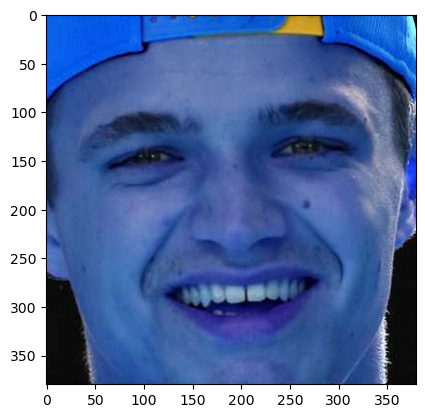

In [9]:
# import an example picture

test_img = cv2.imread('cropped_images/lando_norris/lando_norris_11.jpg')
plt.imshow(test_img)

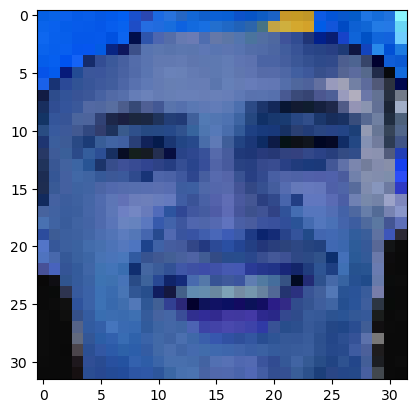

In [10]:
scaled_raw_img = cv2.resize(test_img, (32, 32))
plt.imshow(scaled_raw_img)

In [11]:
scaled_raw_img.shape

(32, 32, 3)

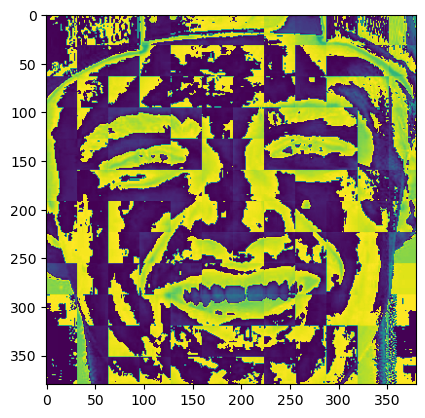

In [12]:
img_har = w2d(test_img,'db1',5)
plt.imshow(img_har)

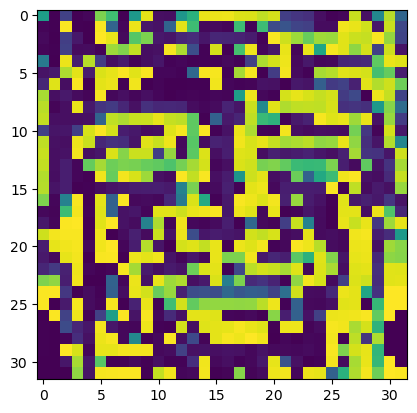

In [13]:
scaled_img_har = cv2.resize(img_har, (32, 32))
plt.imshow(scaled_img_har)

In [14]:
scaled_img_har.shape

(32, 32)

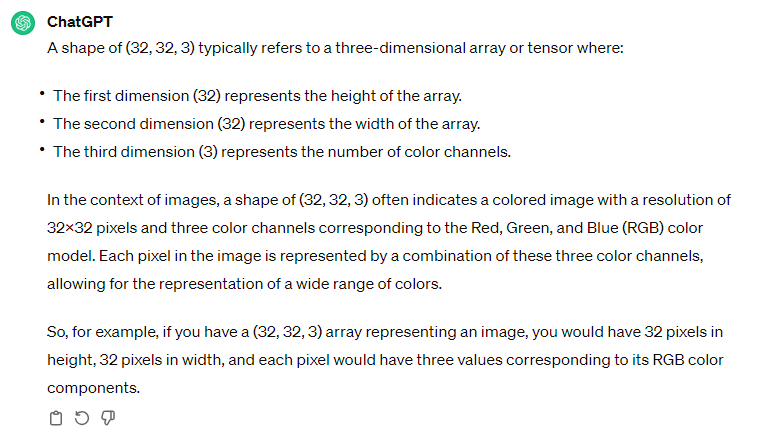


## Reshape

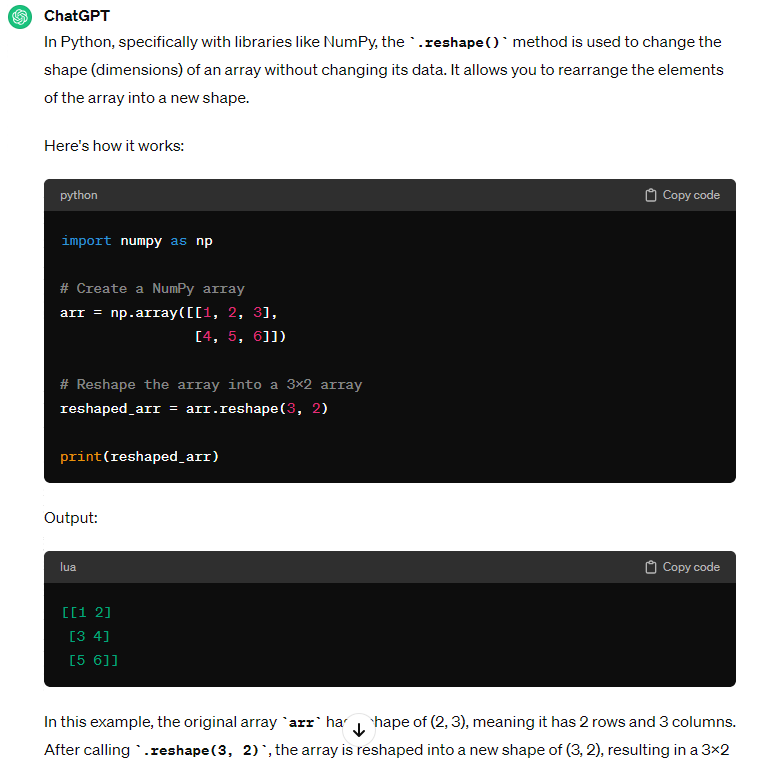

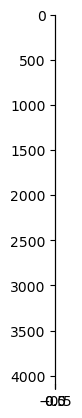

In [15]:
combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))

plt.imshow(combined_img)

In [16]:
combined_img

array([[  5],
       [ 96],
       [228],
       ...,
       [199],
       [255],
       [254]], dtype=uint8)

### Reshaping X and also updating the numbers to be as float

In [17]:
len(X)

1895

In [18]:
X = np.array(X).reshape(len(X),3072).astype(float)
X.shape

(1895, 3072)

In [19]:
len(y)

1895

# Model Building

### Importing libraries

In [20]:
# importing libraries required for model building and 

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# importing a library for visualization

import seaborn as sn

# importing libraries to save the ML model and create JSON files

import joblib 
import json


### Creating a Pipeline

#### What is a Pipeline?

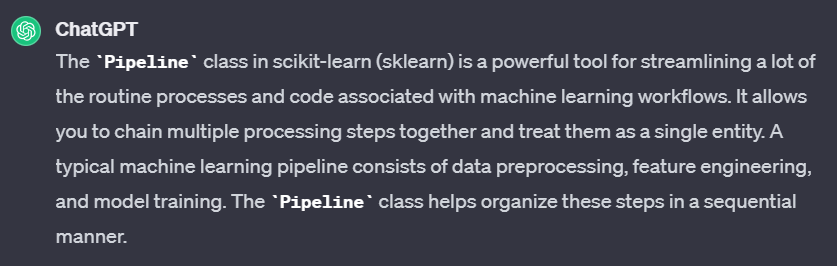

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), # Step 1: Standardize the data
                 ('svc', SVC(kernel = 'rbf', C = 10)) # Step 2: Train a model
                ])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5759493670886076

### Create a classification report that provides precision, recall, and F1-score

In [22]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64        38
           1       0.69      0.60      0.64        30
           2       0.67      0.69      0.68        29
           3       0.58      0.44      0.50        34
           4       0.75      0.38      0.50        24
           5       0.36      0.38      0.37        24
           6       0.46      0.68      0.55        25
           7       0.68      0.83      0.75        18
           8       0.46      0.70      0.55        23
           9       0.51      0.61      0.56        31
          10       0.44      0.61      0.51        18
          11       0.76      0.43      0.55        30
          12       0.83      0.36      0.50        14
          13       0.50      0.56      0.53        18
          14       0.54      0.92      0.68        24
          15       0.81      0.46      0.59        28
          16       0.61      0.58      0.59        19
          17       0.57    

In [23]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Hyperparameter Tuning (SVM vs Random Forest vs Logistic Regression)

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

### Creating a dataframe to compare the best performing model

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

In [ ]:
best_estimators

### Validation set vs Test data set

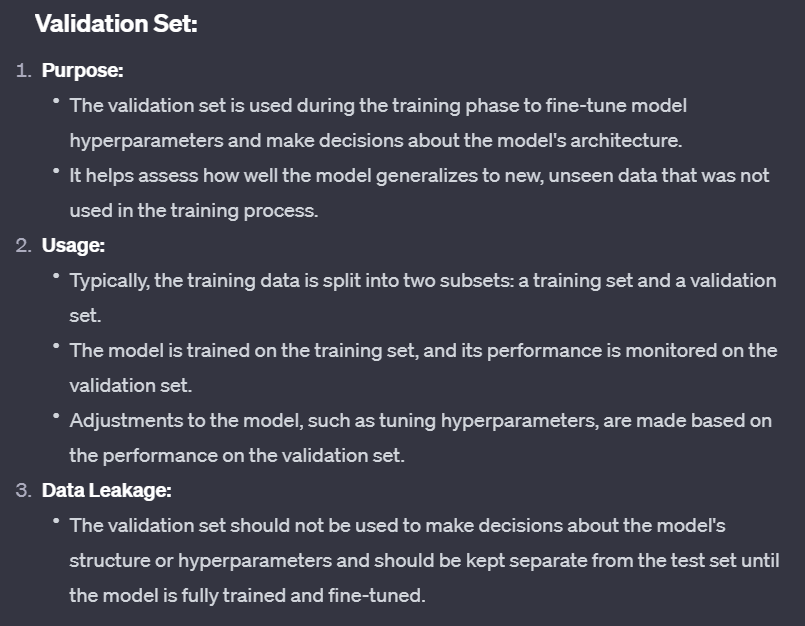

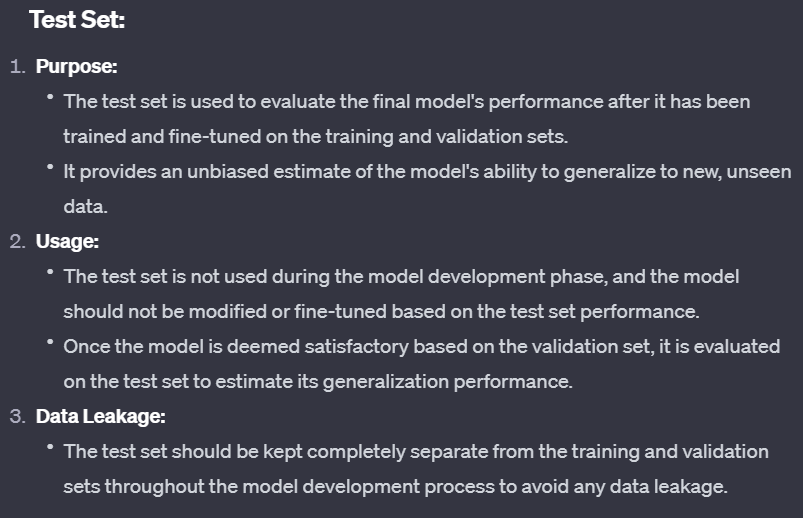

### Testing the model performance with the test data set (not the validation data set as done in the hyperparemeter tuning step)

In [ ]:
best_estimators['svm'].score(X_test,y_test)

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

### Choosing the best performing model

In [ ]:


best_clf = best_estimators['svm']


In [ ]:
best_clf.predict(X_test)

In [ ]:
X_test[5]


In [ ]:
best_clf.predict(X_test[5].reshape(1,-1))

### Plotting the confusion matrix

In [ ]:


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm



In [ ]:

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
class_dict

### Saving the model as pickle file  and create a class dictionary as a JSON file

In [ ]:
# Save the model as a pickle in a file 
import pickle

pickle.dump(best_clf, open('saved_model.pkl', 'wb'))

In [ ]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

